In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os.path
from sklearn.model_selection import train_test_split

In [2]:
PWD = r"C:\Users\Desktop\Sales"

shop_item_pairs_file = "all_data_shop_item_pairs.csv"

level2_train_rf_file = "level2_train_rf.csv"
level2_train_gbm_file = "level2_train_gbm.csv"

level2_test_rf_file = "sklearn_rf_prediction.csv"
level2_test_gbm_file = "lgb_gbm_prediction.csv"

level2_train_rf_df = pd.read_csv(os.path.join(PWD, level2_train_rf_file))
level2_train_gbm_df = pd.read_csv(os.path.join(PWD, level2_train_gbm_file))

level2_test_rf_df = pd.read_csv(os.path.join(PWD, level2_test_rf_file))
level2_test_gbm_df = pd.read_csv(os.path.join(PWD, level2_test_gbm_file))

shop_item_pairs_df = pd.read_csv(os.path.join(PWD, shop_item_pairs_file))


In [3]:
print("level 2 train rf shape", level2_train_rf_df.shape)
level2_train_rf_df.head()


level 2 train rf shape (238172, 2)


,target,rf
0,1.0,0.000
1,1.0,0.850
2,2.0,0.375
3,1.0,0.100
4,1.0,0.825


In [4]:
print("level 2 train gbm shape", level2_train_gbm_df.shape)
level2_train_gbm_df.head()

level 2 train gbm shape (238172, 2)


,target,gbm
0,1.0,0.003950
1,1.0,0.671648
2,2.0,0.461039
3,1.0,0.110168
4,1.0,0.685280


In [5]:
level2_train_df = pd.concat((level2_train_rf_df, level2_train_gbm_df["gbm"]), axis=1)

In [6]:
print("level2 train df shape", level2_train_df.shape)
level2_train_df.head()


level2 train df shape (238172, 3)


,target,rf,gbm
0,1.0,0.000,0.003950
1,1.0,0.850,0.671648
2,2.0,0.375,0.461039
3,1.0,0.100,0.110168
4,1.0,0.825,0.685280


In [7]:
level2_train_all_df = level2_train_df

In [8]:
print("level2_train_all_df shape", level2_train_all_df.shape)
print("level2 RF shape", level2_train_rf_df.shape)
print("level2 GBM shape", level2_train_gbm_df.shape)


level2_train_all_df shape (238172, 3)
level2 RF shape (238172, 2)
level2 GBM shape (238172, 2)


In [9]:
level2_train_X = level2_train_all_df.drop(["target"], axis=1)
level2_train_y = level2_train_all_df["target"]

In [10]:
level2_test_rf_df.head()

,ID,item_cnt_month
0,0,0.700
1,1,3.475
2,2,1.125
3,3,0.700
4,4,0.125


In [11]:
level2_test_gbm_df.head()

,ID,item_cnt_month
0,0,0.663942
1,1,0.354131
2,2,1.138791
3,3,0.423505
4,4,4.283159


In [12]:
level2_test_df = pd.concat((level2_test_rf_df["item_cnt_month"], 
                            level2_test_gbm_df["item_cnt_month"]), 
                           axis=1)

In [13]:
level2_test_df.columns = ["rf", "gbm"]
level2_test_df.head()

,rf,gbm
0,0.700,0.663942
1,3.475,0.354131
2,1.125,1.138791
3,0.700,0.423505
4,0.125,4.283159


In [14]:
def rmse(vec1, vec2):
    from math import sqrt
    from sklearn.metrics import mean_squared_error
    return sqrt(mean_squared_error(vec1, vec2))

In [15]:
train_X_before_split = level2_train_X
train_y_before_split = level2_train_y

(train_X, val_X, train_y, val_y) = train_test_split(train_X_before_split, train_y_before_split, 
                                                    test_size=0.2, random_state=1)

In [16]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(train_X.clip(0,40), train_y.clip(0,40))


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [17]:
lr_pred_val_y = lr.predict(val_X).clip(0,20)
r = rmse(lr_pred_val_y, val_y.clip(0,20))
print("RMSE:", r)

RMSE: 0.8972982003965033


In [18]:
test_X = level2_test_df

In [19]:
lr = LinearRegression()
lr.fit(train_X_before_split.clip(0,40), train_y_before_split.clip(0,40))
level2_pred_test_y = lr.predict(test_X).clip(0,20)

In [20]:
level2_pred_test_y_df = pd.DataFrame(level2_pred_test_y, columns=["item_cnt_month"])
level2_pred_test_y_df.head()

,item_cnt_month
0,0.717255
1,1.246970
2,1.233240
3,0.517072
4,3.567351


In [21]:
level2_pred_test_y_df.to_csv("level2_lr_rf_gbm_prediction.csv", 
                             header=True, index=True, index_label="ID")

In [22]:
plot_df = level2_train_X.clip(0,20).copy()
plot_df = plot_df.melt(None, var_name="Model", value_name="Predict")
plot_df['x'] = np.zeros(plot_df.shape[0])

plot_df.loc[plot_df["Model"] == "rf", 'x'] = np.arange(0, plot_df[plot_df["Model"] == "rf"].shape[0])
plot_df.loc[plot_df["Model"] == "gbm", 'x'] = np.arange(0, plot_df[plot_df["Model"] == "gbm"].shape[0])


In [23]:
plot_df.head()

,Model,Predict,x
0,rf,0.000,0.0
1,rf,0.850,1.0
2,rf,0.375,2.0
3,rf,0.100,3.0
4,rf,0.825,4.0


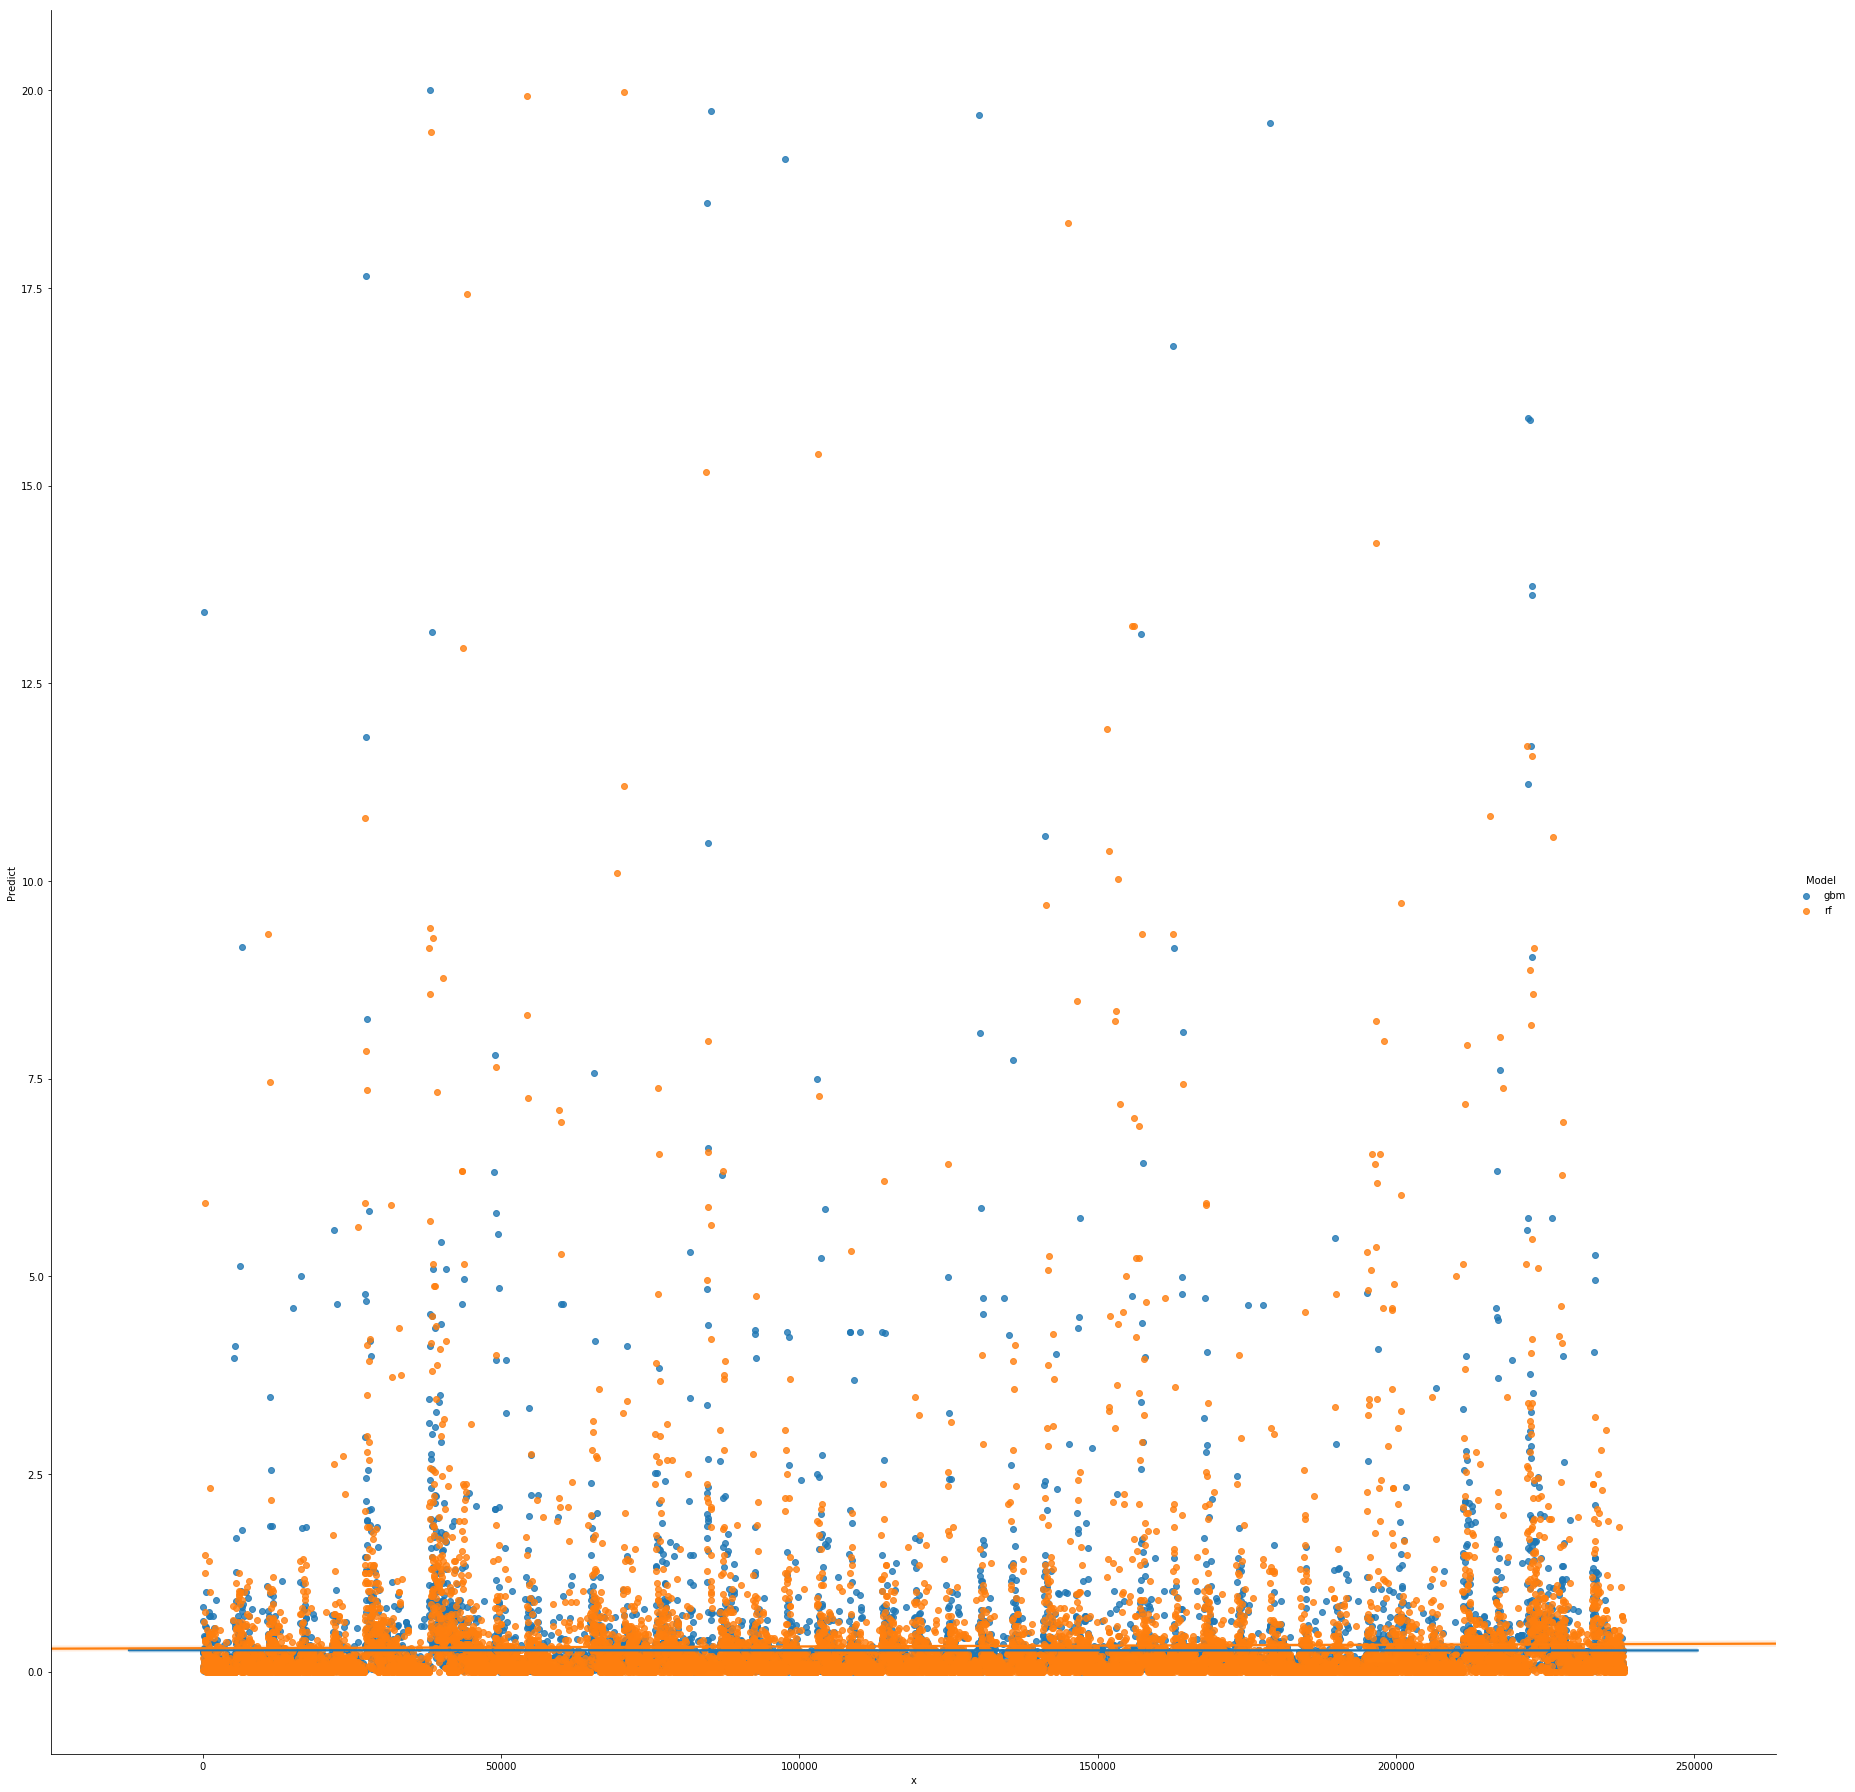

In [24]:
g = sns.lmplot(x="x", y="Predict", hue="Model", 
               data=plot_df.sample(frac=0.05, random_state=1), 
               height=25)